# Havi Random

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
#warnings.filterwarnings('ignore')
%matplotlib inline  

### Optimization 
from scipy.optimize import brute
from scipy import optimize
import scipy.optimize as opt  

### Cluster 
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import GaussianNB
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn import datasets
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.mixture import GMM

### distance Cluster
from sklearn.metrics.pairwise import euclidean_distances
from sklearn import preprocessing


### Outlier detection
from sklearn import svm
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor


## Graph
import plotly.graph_objs as go
from plotly import tools
import plotly.plotly as py
import plotly
loca_path = './'

### Reading the DC Volume and Items data

In [2]:
DC_Volume = pd.read_excel(loca_path+"START HERE_DC Volumes with Case Attributes.xlsx")
items = pd.read_excel(loca_path+"START HERE_DC Volumes with Case Attributes.xlsx", sheetname=1)
s_new_df = pd.read_csv(loca_path+".\HAVI_INBOUND.csv")

In [3]:
l = DC_Volume.apply(lambda row: max(row['WW Case Length'], row['WW Case Width'], row['WW Case Height']), axis=1)
h = DC_Volume.apply(lambda row: min(row['WW Case Length'], row['WW Case Width'], row['WW Case Height']), axis=1)
w = DC_Volume['WW Case Length'] + DC_Volume['WW Case Width'] + DC_Volume['WW Case Height'] - l - h
DC_Volume['WW Case Length'] = l
DC_Volume['WW Case Width'] = w
DC_Volume['WW Case Height'] = h

In [4]:
df_F = DC_Volume[DC_Volume['Wrin Temp Zone']=='F']

In [5]:
# top_15_inF = items[items.F.notnull()][items.Rank.notnull()]['Wrin Prefix'];
# df_F = df_F[df_F['Wrin Prefix'].isin(top_15_inF)];

# Cluster to pick the Size



### Generate Ideal size combinitoin

In [6]:
def ls_candidate_metrix_gen(df,pallet = 'I'):
    if pallet == 'I':# height ,weight,length for pallet
        Hp = 100
        Lp = 48
        Wp = 40
    else:
        Hp = 100
        Lp = 42
        Wp = 29
    df_des = df.describe()
    df_des = df_des.loc[['min','max'],['WW Case Height','WW Case Length','WW Case Width']]
    mat_min_max = np.matrix(df_des)
    ls_h = list(range(int(Hp/mat_min_max[1,0]),int(Hp/mat_min_max[0,0])))
    ls_l = list(range(int(Lp/mat_min_max[1,1]),int(Hp/mat_min_max[0,1])))
    ls_w = list(range(int(Wp/mat_min_max[1,2]),int(Hp/mat_min_max[0,2])))
    ls_h = pd.Series(ls_h)
    ls_l = pd.Series(ls_l)
    ls_w = pd.Series(ls_w)
    ls_h = Hp/ls_h
    ls_l = Lp/ls_l
    ls_w = Wp/ls_w
    ls_candidate = list()
    for i in ls_h:
        for j in ls_l:
            for k in ls_w:
                ls_candidate.append([i,j,k])
    return ls_candidate

In [13]:
def cluster_distance(ls_candidate,X_train,outlier_elim = False ):
    dist_mat = euclidean_distances(X_train,ls_candidate)
    min_dist = np.min(dist_mat,axis=1)
    label = np.argmin(dist_mat,axis=1)
    k = len(np.unique(label))
    ls_num_cluster = list()
    le = preprocessing.LabelEncoder()
    le.fit(np.unique(label))
    ls_num_cluster = le.transform(label)
    if outlier_elim:
        X_train = pd.DataFrame.reset_index(X_train)
        vol = X_train.apply(lambda row: row['WW Case Length']*row['WW Case Width']*row['WW Case Height'], axis=1)
        for i in range(len(label)):
            h,l,w = ls_candidate[label[i]]
            if ((h*l*w)>vol[i]*1.1) or ((h*l*w)<vol[i]*0.9):
                ls_num_cluster[i] = -1
    return ls_num_cluster,k,le

In [60]:
def add_ideal_size(X_train,enconder_for_cluster,ls_candidate):
    X_train['index_candidate'] = 0;
    X_train['index_candidate'].loc[X_train['class'] != -1] = cluster_encode.inverse_transform(X_train['class'].loc[X_train['class'] != -1])
    X_train['ideal_H'] = 0
    X_train['ideal_L'] = 0
    X_train['ideal_W'] = 0
    for i in X_train.index:# check one by one , if the case isn't the outlier, assign new size
        index_candi = int(X_train.loc[i,['index_candidate']])
        if index_candi !=  -1:
            X_train.loc[i,['ideal_H','ideal_L','ideal_W']] = ls_candidate[index_candi]
    return X_train

### Apply to all the case

#### F

In [71]:
df_F = DC_Volume[DC_Volume['Wrin Temp Zone']=='F']
X_train = df_F.loc[:,['WW Case Height','WW Case Length', 'WW Case Width']]
ls_candidate = ls_candidate_metrix_gen(X_train)
X_train['class'],k ,cluster_encode= cluster_distance(ls_candidate,X_train,True)
X_train = add_ideal_size(X_train,cluster_encode,ls_candidate)
cluster_plot(X_train,k)

C:\Program Files\Anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [74]:
X_train[X_train.index_candidate == 0]

,WW Case Height,WW Case Length,WW Case Width,class,index_candidate,ideal_H,ideal_L,ideal_W
5,8.00,19.50,12.00,-1,0,14.285714,24.0,20.0
6,8.12,20.25,12.00,-1,0,14.285714,24.0,20.0
7,8.00,19.50,12.00,-1,0,14.285714,24.0,20.0
8,7.81,20.50,10.13,-1,0,14.285714,24.0,20.0
9,8.25,20.50,10.19,-1,0,14.285714,24.0,20.0
10,8.25,20.50,10.19,-1,0,14.285714,24.0,20.0
42,9.44,13.94,11.63,-1,0,14.285714,24.0,20.0
43,9.44,13.94,11.63,-1,0,14.285714,24.0,20.0
44,9.44,13.94,11.63,-1,0,14.285714,24.0,20.0
144,12.19,15.25,12.75,-1,0,14.285714,24.0,20.0


In [68]:
df_F = DC_Volume[DC_Volume['Wrin Temp Zone']=='F']
X_train = df_F.loc[:,['WW Case Height','WW Case Length', 'WW Case Width']]
ls_candidate = ls_candidate_metrix_gen(X_train)
X_train['class'],k,cluster_encode = cluster_distance(ls_candidate,X_train,False)
X_train = add_ideal_size(X_train,cluster_encode,ls_candidate)
cluster_plot(X_train,k)

C:\Program Files\Anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [70]:
X_train

,WW Case Height,WW Case Length,WW Case Width,class,index_candidate,ideal_H,ideal_L,ideal_W
0,13.13,16.38,13.50,0,49,12.500000,16.0,13.333333
1,12.38,16.00,13.00,0,49,12.500000,16.0,13.333333
2,12.38,16.00,13.00,0,49,12.500000,16.0,13.333333
3,13.00,15.88,13.75,0,49,12.500000,16.0,13.333333
4,12.38,16.00,13.00,0,49,12.500000,16.0,13.333333
5,8.00,19.50,12.00,13,249,7.692308,16.0,13.333333
6,8.12,20.25,12.00,8,201,8.333333,24.0,13.333333
7,8.00,19.50,12.00,13,249,7.692308,16.0,13.333333
8,7.81,20.50,10.13,12,242,7.692308,24.0,10.000000
9,8.25,20.50,10.19,9,202,8.333333,24.0,10.000000


#### D

In [467]:
df_D = DC_Volume[DC_Volume['Wrin Temp Zone']=='D']
X_train = df_D.loc[:,['WW Case Height','WW Case Length', 'WW Case Width']]
ls_candidate = ls_candidate_metrix_gen(X_train)
X_train['class'],k ,cluster_encode= cluster_distance(ls_candidate,X_train,True)
X_train = add_ideal_size(X_train,cluster_encode,ls_candidate)
cluster_plot(X_train,k)

In [468]:
df_D = DC_Volume[DC_Volume['Wrin Temp Zone']=='D']
X_train = df_D.loc[:,['WW Case Height','WW Case Length', 'WW Case Width']]
ls_candidate = ls_candidate_metrix_gen(X_train)
X_train['class'],k,cluster_encode = cluster_distance(ls_candidate,X_train,False)
X_train = add_ideal_size(X_train,cluster_encode,ls_candidate)
cluster_plot(X_train,k)

#### R

In [469]:
df_R = DC_Volume[DC_Volume['Wrin Temp Zone']=='R']
X_train = df_R.loc[:,['WW Case Height','WW Case Length', 'WW Case Width']]
ls_candidate = ls_candidate_metrix_gen(X_train)
X_train['class'],k ,cluster_encode= cluster_distance(ls_candidate,X_train,True)
X_train = add_ideal_size(X_train,cluster_encode,ls_candidate)
cluster_plot(X_train,k)

In [67]:
df_R = DC_Volume[DC_Volume['Wrin Temp Zone']=='R']
X_train = df_R.loc[:,['WW Case Height','WW Case Length', 'WW Case Width']]
ls_candidate = ls_candidate_metrix_gen(X_train)
X_train['class'],k,cluster_encode = cluster_distance(ls_candidate,X_train,False)
X_train = add_ideal_size(X_train,cluster_encode,ls_candidate)
cluster_plot(X_train,k)

C:\Program Files\Anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



### Crete objection function

In [12]:
def space_coef(input_size,*param):
    in_val = space_coef_input(input_size,*param)
    out_val  = space_coef_outbound(input_size,*param)
    return -(in_val**2 + out_val**2)**0.5

In [13]:
##  Maximum volume efficiency
#def space_coef(input_size,pallet ='O'):
def space_coef_input(input_size,*param):
    ## Define the pallet
    height,length,width = input_size
    pallet ='O'
#     if params:
#         pallet = params
#     else:
#         pallet = 'O'
        
    coef = 0
    if pallet == 'O':# height ,weight,length for pallet
        Hp = 100
        Lp = 48
        Wp = 40
    else:
        Hp = 100
        Lp = 42
        Wp = 29
    vol_case = height*length*width
    num_H = np.floor(Hp/height)
    num_L = np.floor(Lp/length)
    num_W = np.floor(Wp/width)
    coef = num_H*num_L*num_W*(vol_case)/(Hp*Lp*Wp)
    # since all the optimization function I can find so far is about to find minimum value, 
    # that's the most easy way to get the value right...
    return -coef
    

In [14]:
##  Maximum volume efficiency
#def space_coef(input_size,pallet ='O'):
def space_coef_outbound(input_size,*param):
    ## Define the pallet
    height,length,width = input_size
    pallet ='I'
#     if params:
#         pallet = params
#     else:
#         pallet = 'O'
        
    coef = 0
    if pallet == 'O':# height ,weight,length for pallet
        Hp = 100
        Lp = 48
        Wp = 40
    else:
        Hp = 100
        Lp = 42
        Wp = 29
    vol_case = height*length*width
    num_H = np.floor(Hp/height)
    num_L = np.floor(Lp/length)
    num_W = np.floor(Wp/width)
    coef = num_H*num_L*num_W*(vol_case)/(Hp*Lp*Wp)
    # since all the optimization function I can find so far is about to find minimum value, 
    # that's the most easy way to get the value right...
    return -coef

In [15]:
#brief create interval for the matrix, want to use 0.2 inch as an unit.
#input mat it should be np.array, n x 3 matrix
#input
#Return:   2 element list, lower bound,  upeper bound
def UpLowbound_gen(mat,limit = 'vol'):
    pect_ = 1.1 # 10% increase or decreaase
    unit = 1/0.2
    if limit =='vol':
        pect_ = pect_ ** (1. / 3)

    else:
        pect_ = pect_
        
    upper_mat = np.multiply(mat,pect_)
    upper_mat = np.divide(np.floor(np.multiply(upper_mat,unit)),unit)
    lower_mat = np.around(np.divide(mat,pect_),decimals=2)
    lower_mat = np.divide(np.ceil(np.multiply(lower_mat,unit)),unit)
    return lower_mat, upper_mat,np.dstack([lower_mat,upper_mat])

### GMM model for cluster

In [ ]:
gmm = GMM(n_components=5).fit(X_train.iloc[:,:3])

In [169]:
labels = gmm.predict(X_train.iloc[:,:3])

C:\Program Files\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:75: DeprecationWarning:

Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.



In [171]:
X = X_train.iloc[:,:3]

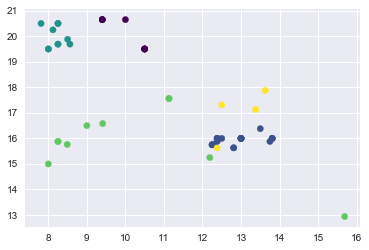

In [174]:
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=labels, s=40, cmap='viridis');

elbow method for getting the number of clusters

### silhouette_score for Picking Cluster number
~~~ modified by grid search. later.

In [15]:
def silhouette_score_cluster_num(df):
    ls_sil = list()
    for i in range(2,len(df)):
        kmean_estimators  = KMeans(n_clusters=i)
        kmean_estimators.fit(X_train)
        labels = kmean_estimators.labels_
        score = silhouette_score(df, labels, metric='euclidean')
        ls_sil.append(score)
    return np.argmax(ls_sil)+2

### Remove outlier by one cluster SVM

In [16]:
def cluster_outlier(df):
    n_samples = df_F.shape[0]
    # define two outlier detection tools to be compared
    clf = svm.OneClassSVM(nu=0.05, kernel="rbf", gamma=0.1)
    clf.fit(df)
    ls_outlier = clf.predict(df)
    return ls_outlier

In [18]:
def outlier_marker(df,k,method = 'OSVM',label = None):
    if method =='OSVM':
        for i in range(k):
            ls_outlier_result = cluster_outlier(df[df['class'] == i].iloc[:,0:3])
            ls_index = df[df['class'] == i].index
            for j in range(len(ls_outlier_result)):
                if ls_outlier_result[j] == -1:
                    df.loc[ls_index[j],['class']] = -1
        return df
    elif method == 'distance':
        return df
        

### Pick the best K from silhouette_score
K number dcided by solhoutte number


In [26]:
k = silhouette_score_cluster_num(X_train);k

37

In [31]:
kmean_estimators  = KMeans(n_clusters=10)
kmean_estimators.fit(X_train)
labels = kmean_estimators.labels_
X_train['class'] = labels

In [32]:
X_train = outlier_marker(X_train,k);

ValueError: Found array with 0 sample(s) (shape=(0, 3)) while a minimum of 1 is required.

In [33]:
cluster_plot(X_train,k)

### Plot 3-D graph

In [66]:
def color_gen(num):
    ls_color =list()
    for i in range(num):
        ls_color.append("rgb({0:d},{1:d},{2:d})".format(int(np.random.uniform(128,255,1)),int(np.random.uniform(0,255,1)),int(np.random.uniform(0,255,1))))
    return ls_color

In [64]:
def cluster_plot(X_train,k):
    data = []
    clusters = []
    colors = color_gen(k)
    for i in range(k):
        color =  colors[i]
        dx = X_train[X_train['class'] == i].iloc[:, 0],
        dy = X_train[X_train['class'] == i].iloc[:,  1],
        dz = X_train[X_train['class'] == i].iloc[:,  2],
        x = dx[0]
        y = dy[0]
        z = dz[0]
        trace = go.Scatter3d(
            x = x, y = y, z = z,   
            mode = 'markers',
            marker = dict( size=10, color=color, line=dict(width=0) ) )
        data.append( trace )

    color =  'rgb(0,0,0)'
    dx = X_train[X_train['class'] == -1].iloc[:, 0],
    dy = X_train[X_train['class'] == -1].iloc[:,  1],
    dz = X_train[X_train['class'] == -1].iloc[:,  2],
    x = dx[0]
    y = dy[0]
    z = dz[0]
    trace = go.Scatter3d(
        x = x, y = y, z = z,   
        mode = 'markers',
        marker = dict( size=10, color=color, line=dict(width=0) ) )
    data.append( trace )


    layout = go.Layout(
        title='Plot Title',
        xaxis=dict(
            title='x Axis',
            titlefont=dict(
                family='Courier New, monospace',
                size=18,
                color='#7f7f7f'
            )
        ),
        yaxis=dict(
            title='y Axis',
            titlefont=dict(
                family='Courier New, monospace',
                size=18,
                color='#7f7f7f'
            )
        )
    )
    fig = go.Figure(data=data, layout=layout)
    plotly.offline.plot(fig, filename='simple-3d-scatter.html')

In [299]:
X_train = s_new_df[s_new_df["Wrin Temp Zone"] =='F'].iloc[:,1:4]

In [300]:
k = silhouette_score_cluster_num(X_train);k

5

In [301]:
kmean_estimators  = KMeans(n_clusters=k)
kmean_estimators.fit(X_train)
labels = kmean_estimators.labels_
X_train['class'] = labels

In [302]:
X_train['class'].unique()

array([1, 3, 0, 4, 2], dtype=int64)

In [303]:
X_train = outlier_marker(X_train,k);

In [304]:
X_train['class'].unique()

array([ 1, -1,  0,  4,  2,  3], dtype=int64)

In [305]:
cluster_plot(X_train,k)

## Generate Case new size

In [158]:
## to get the H,L,W range. 
kmean_estimators.cluster_centers_= X_train.iloc[:,0:3] ## Put the all data into optmize
Lmat,Umat ,ULmat = UpLowbound_gen(kmean_estimators.cluster_centers_)
ideal_input_size = list()
for limit in ULmat:
    H_MinMax, L_MinMax, W_MinMax = limit
    rranges = (slice(H_MinMax[0],H_MinMax[1], 0.2), slice(L_MinMax[0],L_MinMax[1], 0.2)
           ,slice(W_MinMax[0],W_MinMax[1], 0.2))
    resbrute = brute(space_coef_input, rranges, full_output=True, finish=None)
    ideal_input_size.append(resbrute[0])## ideal size is correspond to original cluster center.

In [267]:
df_R = DC_Volume[DC_Volume['Wrin Temp Zone']=='R']

In [268]:
X_train = df_R.loc[:,['WW Case Height','WW Case Length', 'WW Case Width']]

In [271]:
kmean_estimators  = KMeans(n_clusters=5)
kmean_estimators.fit(X_train)
labels = kmean_estimators.labels_
X_train['class'] = labels

In [272]:
X_train = outlier_marker(X_train,5);

In [309]:
d = kmean_estimators.transform(X_train.iloc[:,:3])

## Understanding the data

### Mismatch of items

In comparing the unique "WRIN PREFIX", the following items are missing from "DC Volumes" and "Xtab-Temp Zone X WRIN" sheets.
1. 00042-DIET COKE SYRUP - with 152,368 cases received
2. 00168-SPRITE DRINK SYRUP - with 142,032 cases received

Both the WRIN PREFIX has temperature zone as Dry with the same Supplier "COCA-COLA COMPANY (THE)/MCDONALDS ACCOUNT GROUP". Adding these two tiems in the "Xtab-Temp Zone X WRIN" sheet will change the rank of other items.

In [ ]:
temperature = ('F', 'R', 'D')
for i in temperature:
    print("Temp zone", i ,"missing:",set(DC_Volume['Wrin Prefix'][DC_Volume['Wrin Temp Zone'] == i].unique()).symmetric_difference(set(items['Wrin Prefix'][items[i].notnull()].unique())))

In [ ]:
print("Total number of items manufactured and distributed:",len(DC_Volume['Wrin Prefix'].unique()), "items")
print("Number of DCs:", DC_Volume['DC ID'].unique())
print("Total number of suppliers:",len(DC_Volume['Supplier Parent Name'].unique()))
print("Freezer items:",len(DC_Volume['Wrin Prefix'][DC_Volume['Wrin Temp Zone'] == "F"].unique()))
print("Dry items:",len(DC_Volume['Wrin Prefix'][DC_Volume['Wrin Temp Zone'] == "D"].unique()))
print("Refrigerator items:",len(DC_Volume['Wrin Prefix'][DC_Volume['Wrin Temp Zone'] == "R"].unique()))

### Wrong Temperature Zone

"LOPEZ FOOD INC" is the only Supplier to pack Beef patty in Temp Zone "R" and sent 105 cases in total. They are also responsible for sending "Canadian Bacon/Natural juice" in Temp Zone "R"

In [ ]:
DC_Volume[(DC_Volume['Wrin Prefix']=='00006-4/1 BEEF PATTY') & (DC_Volume['Wrin Temp Zone']=='R')]

Find the most number of cases sent by a supplier

Why is 1 item measured in KG but the gross weight in LBS. is this typo error?

Check what all items goes to each DCs

### Basic visualization

In [ ]:
#Top and least suppliers for Mcdonalds
#plt.figure()

plt.figure(figsize=(50,20))
plt.subplot(121)

df = DC_Volume[['Supplier Parent Name','DC Receipts Cases Received']]
df['Supplier Parent Name']=df['Supplier Parent Name'].replace(['COCA-COLA COMPANY (THE)/MCDONALDS ACCOUNT GROUP'],value='COCA-COLA MCD')
df['Supplier Parent Name']=df['Supplier Parent Name'].replace(['COCA-COLA COMPANY (THE)/MOTHER PARKERS FOODS LTD'],value='COCA-COLA Mother')
grouped = df.groupby(df['Supplier Parent Name']).sum().reset_index()
grouped = grouped.sort_values('DC Receipts Cases Received', ascending = False)
sns.barplot(grouped['Supplier Parent Name'][:15], grouped['DC Receipts Cases Received'][:15])
plt.title("Top 15 Suppliers",size=50)
plt.ylabel("Cases Recevied by DC",size=40)
plt.xticks(rotation=90,size=30)
plt.yticks(size=30)
plt.xlabel('Supplier Name',size=50)

plt.subplot(122)
sns.barplot(grouped['Supplier Parent Name'][-15:], grouped['DC Receipts Cases Received'][-15:])
plt.title("Least 15 Suppliers",size=50)
plt.ylabel("Cases Recevied by DC",size=40)
plt.xticks(rotation=90,size=30)
plt.yticks(size=30)
plt.xlabel('Supplier Name',size=50)
plt.show()


# DC outbound

In [ ]:
df_outbound = pd.read_excel(loca_path+"DC Sales_DC7.xlsx")

In [ ]:
df_outbound.head(1)

In [ ]:
len(df_outbound['Rest ID'].unique())